In [1]:
import shap 
import torch 
import numpy as np 
from matplotlib import pyplot as plt 
import pandas as pd 
from torch.utils.data import DataLoader
import scipy
import torch_geometric as pyg 
import umap 
import seaborn as sbn
import networkx as nx 
from sklearn.decomposition import PCA
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import gseapy as gp
import pickle as pkl 
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix 
import omnipath as op
import matplotlib.patches as mpatches

import sys 
sys.path.append('../')
import src.models.utils as utils
from src.data.LincsDataset import LincsDataset
import captum

from src.interpret.extract_entity_function import extract_entity_function
from src.interpret.GSNNExplainer import GSNNExplainer 

%load_ext autoreload
%autoreload 2

/home/teddy/miniconda3/envs/grcp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Computing Edge Importance Scores 



To compute edge importance scores, we will use a method analagous to `GNNExplainer` proposed by Ying et al (https://arxiv.org/pdf/1903.03894.pdf). This method formulates explanation of a variable as a secondary optimization problem, whose task is to find an edge mask that maintains model predictions, thereby identifying a subgraph of important edges. We approach this similarly, with a slightly different objective suitable for multi-output regression predictions. 

In [2]:
siginfo = pd.read_csv('../../data/siginfo_beta.txt', sep='\t', low_memory=False)

In [3]:
model = torch.load('../output/exp4-1/GSNN/ef2aa31f-0c57-4210-b12a-68859ed6b1d2/model.pt').cpu().eval()
data = torch.load('../output/exp4-1/GSNN/ef2aa31f-0c57-4210-b12a-68859ed6b1d2/Data.pt')
proc = '../output/exp4-1/proc/'

In [113]:
ids = np.array(np.load(f'{proc}/train_obs.npy', allow_pickle=True).tolist() + np.load(f'{proc}/test_obs.npy', allow_pickle=True).tolist() + np.load(f'{proc}/val_obs.npy', allow_pickle=True).tolist())

dataset = LincsDataset(proc, ids)
loader = DataLoader(dataset, batch_size=100, shuffle=False)

X = []
sig_ids = []
for i,(x, y, sig_id) in enumerate(loader): 
    X.append(x)
    sig_ids += list(sig_id)

X = torch.cat(X, dim=0)
X.size()

torch.Size([28052, 4988, 1])

In [114]:
#np.sort(data.cellspace)

r_drug_dict = pkl.load(open('../output/exp4-1/GSNN/ef2aa31f-0c57-4210-b12a-68859ed6b1d2/r_drug_dict.pkl', 'rb'))
druginfo = pd.read_csv('../../data/compoundinfo_beta.txt', sep='\t')[['pert_id', 'moa', 'cmap_name', 'compound_aliases']].drop_duplicates()
drugperf = pd.DataFrame(r_drug_dict, index=[0]).T.reset_index().rename({'index':'pert_id', 0:'r'}, axis=1).sort_values(by='r', ascending=False).merge(druginfo, on='pert_id', how='left')
drugperf.head()

,pert_id,r,moa,cmap_name,compound_aliases
0,BRD-K61397605,0.826100,HDAC inhibitor,romidepsin,NaN
1,BRD-K56957086,0.800913,HDAC inhibitor,dacinostat,NaN
2,BRD-K83837640,0.768272,HDAC inhibitor,JNJ-26481585,JNJ-26854165
3,BRD-K49371609,0.761629,PI3K inhibitor,PIK-75,NaN
4,BRD-K49371609,0.761629,DNA protein kinase inhibitor,PIK-75,NaN


In [115]:
sigidinfo = siginfo.merge(pd.DataFrame({'sig_id':sig_ids}), on='sig_id', how='right')
sigidinfo.head()

,bead_batch,nearest_dose,pert_dose,pert_dose_unit,pert_idose,pert_itime,pert_time,pert_time_unit,cell_mfc_name,pert_mfc_id,...,cell_iname,det_wells,det_plates,distil_ids,build_name,project_code,cmap_name,is_exemplar_sig,is_ncs_sig,is_null_sig
0,b18,10.00,10.0,uM,10 uM,24 h,24.0,h,A549,BRD-K88551539,...,A549,M08,LUNG001_A549_24H_X2_B18,LUNG001_A549_24H_X2_B18:M08,NaN,LUNG,CAY-10585,0,0.0,0.0
1,b18,1.11,1.0,uM,1.11 uM,24 h,24.0,h,BT474,BRD-K19687926,...,BT474,J10|J11|J12,ERBB2001_BT474_24H_X1_B18,ERBB2001_BT474_24H_X1_B18:J10|ERBB2001_BT474_2...,NaN,ERBB2,lapatinib,0,0.0,0.0
2,b18,10.00,10.0,uM,10 uM,24 h,24.0,h,A549,BRD-K68488863,...,A549,P22,LUNG001_A549_24H_X2_B18,LUNG001_A549_24H_X2_B18:P22,NaN,LUNG,ENMD-2076,0,0.0,0.0
3,b14,4.00,5.0,uM,4 uM,24 h,24.0,h,22RV1,BRD-K51544265,...,22RV1,I22|J23|K24|L17|M18|N19|O20|P21,DTAK001_22RV1_24H_X2_B14,DTAK001_22RV1_24H_X2_B14:I22|DTAK001_22RV1_24H...,NaN,DTAK,cabozantinib,0,0.0,0.0
4,b18,0.12,0.1,uM,0.12 uM,24 h,24.0,h,BT474,BRD-K19687926,...,BT474,I10|I11|I12,ERBB2001_BT474_24H_X1_B18,ERBB2001_BT474_24H_X1_B18:I10|ERBB2001_BT474_2...,NaN,ERBB2,lapatinib,0,0.0,0.0


In [116]:
drugperf.merge(sigidinfo.groupby('pert_id').count()['sig_id'].sort_values().reset_index(), on='pert_id', how='left')[lambda x: x.cmap_name.isin(['lapatinib', 'neratinib', 'tucatinib', 'palbociclib'])]

,pert_id,r,moa,cmap_name,compound_aliases,sig_id
105,BRD-K85606544,0.262945,EGFR inhibitor,neratinib,NaN,159
221,BRD-K19687926,0.092817,EGFR inhibitor,lapatinib,NaN,348
222,BRD-K19687926,0.092817,ErbB2 inhibitor,lapatinib,NaN,348


In [117]:
# neratinib: BRD-K85606544	0.262945	EGFR inhibitor	neratinib	NaN	159 
# breast cancer TKI 
# EGFR/HER2 canonically targets three transcription factors: ELK, NF-kB, FOXO 
# ELK1_HUMAN -> P19419 
# NF-kB -> A0A510GAH8, H2QPY8
# FOXO1_HUMAN -> Q12778


In [118]:
# lapatinib : BRD-K19687926

In [119]:
doro = op.interactions.Dorothea().get()
doro.head()

,source,target,is_directed,is_stimulation,is_inhibition,consensus_direction,consensus_stimulation,consensus_inhibition,curation_effort,references,sources,references_stripped,n_references,n_sources,n_primary_sources
0,P01106,O14746,True,True,False,True,True,False,77,CollecTRI:10022128;CollecTRI:10491298;CollecTR...,CollecTRI;DoRothEA;ExTRI_CollecTRI;HTRI_Collec...,10022128;10491298;10606235;10625678;10637317;1...,75,15,4
1,P84022,P05412,True,True,False,True,True,False,3,CollecTRI:10022869;CollecTRI:12374795;DoRothEA...,CollecTRI;DoRothEA;ExTRI_CollecTRI;NTNU.Curate...,10022869;12374795,2,10,2
2,Q13485,P05412,True,True,False,True,True,False,3,CollecTRI:10022869;CollecTRI:12374795;DoRothEA...,CollecTRI;DoRothEA;ExTRI_CollecTRI;NTNU.Curate...,10022869;12374795,2,10,2
3,P08047,P04075,True,True,False,True,True,False,4,CollecTRI:10023068;CollecTRI:8524331;DoRothEA:...,CollecTRI;DoRothEA;ExTRI_CollecTRI;ORegAnno;OR...,10023068;8524331,2,10,3
4,P04637,P08069,True,False,True,True,False,True,13,CollecTRI:10023442;CollecTRI:11001824;CollecTR...,CollecTRI;DoRothEA;ExTRI_CollecTRI;GEREDB_Coll...,10023442;11001824;12089352;12444079;15131018;1...,13,11,2


In [120]:
uni2gene = pd.read_csv('../extdata/omnipath_uniprot2genesymb.tsv', sep='\t')
uni2gene[lambda x: x.To.str.contains('FOXO')]

,From,To
1518,A8MYZ6,FOXO6
5078,P98177,FOXO4
9962,O43524,FOXO3
15417,Q12778,FOXO1
16346,A0A2Z4LIS9,FOXO3B


In [121]:
'H2QPY8' in doro.source.values

False

In [122]:
'PROTEIN__Q12778' in data.node_names

False

In [123]:
src,dst = data.node_names[data.edge_index]
ELK_targets = (np.isin(src, ['PROTEIN__P19419', 'PROTEIN__P28324', 'PROTEIN__P41970'])).sum()
NFkB_targets = (np.isin(src, ['PROTEIN__P19838', 'PROTEIN__Q00653'])).sum()
FOXO1_targets = (np.isin(src, ['PROTEIN__Q12778', 'PROTEIN__O43524', 'PROTEIN__P98177', 'PROTEIN__A8MYZ6'])).sum()
print('# ELK targets:', ELK_targets)
print('# NFkB targets:', NFkB_targets)
print('# FOXO1 targets:', FOXO1_targets)

# ELK targets: 44
# NFkB targets: 0
# FOXO1 targets: 0


In [124]:
ELK_LINCS_targets = [f'LINCS__{x.split("__")[-1]}' for x in dst[np.isin(src, ['PROTEIN__P19419', 'PROTEIN__P28324', 'PROTEIN__P41970'])] if (f'LINCS__{x.split("__")[-1]}' in data.node_names) and (x.split("__")[0] == 'RNA')]
ELK_LINCS_targ_idxs = [data.node_names.tolist().index(x) for x in ELK_LINCS_targets]
ELK_LINCS_targets

['LINCS__P18146',
 'LINCS__P01100',
 'LINCS__Q9NX09',
 'LINCS__Q15746',
 'LINCS__P20226',
 'LINCS__P15407',
 'LINCS__P55055',
 'LINCS__P04626',
 'LINCS__Q07960',
 'LINCS__P46527',
 'LINCS__Q8IWX8']

In [159]:
sigidinfo[lambda x: (x.pert_id == 'BRD-K85606544') & (x.pert_dose == 10)][['sig_id', 'cell_iname', 'pert_id', 'pert_dose']][lambda x: x.cell_iname.isin(['BT20', 'SKBR3', 'MCF7'])] # neratinib 
#sigidinfo[lambda x: (x.pert_id == 'BRD-K19687926') & (x.pert_dose == 10)][['sig_id', 'cell_iname', 'pert_id', 'pert_dose']][lambda x: x.cell_iname.isin(['BT20', 'SKBR3', 'MCF7'])] # lapatinib 

,sig_id,cell_iname,pert_id,pert_dose
5281,CPC006_MCF7_24H:J21,MCF7,BRD-K85606544,10.0
7369,LJP001_MCF7_24H:BRD-K85606544-001-04-2:10,MCF7,BRD-K85606544,10.0
7479,LJP005_MCF7_24H:A13,MCF7,BRD-K85606544,10.0
7539,LJP001_SKBR3_24H:C15,SKBR3,BRD-K85606544,10.0
14595,REP.A021_MCF7_24H:M19,MCF7,BRD-K85606544,10.0
26244,LJP001_BT20_24H:BRD-K85606544-001-04-2:10,BT20,BRD-K85606544,10.0


In [160]:
                    # lapatinib || neratinib 
bt20idx = 26244     # 24743    #||  26244# breast cancer 
mcf7idx = 14595      # 9315     #||  14595# breast 
skbr3idx = 7539     # 6979    #||  7539 # breast (HER2+)

#print(np.abs(model.cpu()(X[[bt20idx]])[:, ELK_LINCS_targ_idxs]).mean())
#print(np.abs(model.cpu()(X[[mcf7idx]])[:, ELK_LINCS_targ_idxs]).mean())
#print(np.abs(model.cpu()(X[[skbr3idx]])[:, ELK_LINCS_targ_idxs]).mean())

print(np.abs(model.cpu()(X[[bt20idx]]).detach()).mean())
print(np.abs(model.cpu()(X[[mcf7idx]]).detach()).mean())
print(np.abs(model.cpu()(X[[skbr3idx]]).detach()).mean())

tensor(0.0724)
tensor(0.0473)
tensor(0.0575)


In [260]:
explainer = GSNNExplainer(model, data, hard=True, prior=3, normalize_target=True)
NERATINIB_bt20 = explainer.explain(X[[bt20idx]], targets=data.output_node_mask.nonzero(as_tuple=True)[0], weight_decay=1e-5, beta=1e-4, iters=2500, lr=1e-2, batch=1, desired_edges=750.)

mean, std: (tensor(0.0001, device='cuda:0'), tensor(0.3464, device='cuda:0'))


In [261]:
# HER2 -- PROTEIN__P04626
# lapatinib : BRD-K19687926
# neratinib : DRUG__BRD-K85606544
NERATINIB_bt20.set_index('source').loc['DRUG__BRD-K85606544']

,target,score
source,,
DRUG__BRD-K85606544,PROTEIN__P00533,0.999189
DRUG__BRD-K85606544,PROTEIN__P04626,0.945982


In [262]:
NERATINIB_bt20[lambda x: x.score > 0.5][lambda x: x.source.str.contains('DRUG__')].sort_values(by='score', ascending=False).head(25)

,source,target,score
11157,DRUG__BRD-K85606544,PROTEIN__P00533,0.999189
10297,DRUG__BRD-K02130563,PROTEIN__O15379,0.991883
10692,DRUG__BRD-K50168500,PROTEIN__P00533,0.991362
10320,DRUG__BRD-K07487750,PROTEIN__P00533,0.990256
11176,DRUG__BRD-K87909389,PROTEIN__P00533,0.987582
10850,DRUG__BRD-K66175015,PROTEIN__P00533,0.987356
10422,DRUG__BRD-K23190681,PROTEIN__P00533,0.986429
11165,DRUG__BRD-K86797399,PROTEIN__O15379,0.986254
10739,DRUG__BRD-K57169635,PROTEIN__P00533,0.980606
10756,DRUG__BRD-K61397605,PROTEIN__O15379,0.979924


In [209]:
explainer = GSNNExplainer(model, data, hard=False, prior=2, normalize_target=False)
NERATINIB_mcf7 = explainer.explain(X[[mcf7idx]], targets=data.output_node_mask.nonzero(as_tuple=True)[0], weight_decay=1e-6, beta=5e-4, iters=1000, lr=1e-1, batch=10, desired_edges=750.)

In [264]:
NERATINIB_mcf7[lambda x: x.score > 0.5][lambda x: x.source.str.contains('DRUG__')].sort_values(by='score', ascending=False).head(25)

,source,target,score
11157,DRUG__BRD-K85606544,PROTEIN__P00533,0.999801


In [263]:
explainer = GSNNExplainer(model, data, hard=True, prior=3, normalize_target=True)
NERATINIB_skbr3 = explainer.explain(X[[skbr3idx]], targets=data.output_node_mask.nonzero(as_tuple=True)[0], weight_decay=1e-5, beta=1e-4, iters=2500, lr=1e-2, desired_edges=750.)

z-scoring target || (target dist params) mean, std: (tensor(-0.0009, device='cuda:0'), tensor(0.2662, device='cuda:0'))


In [266]:
# HER2 -- PROTEIN__P04626
# lapatinib : BRD-K19687926
# neratinib : DRUG__BRD-K85606544
NERATINIB_skbr3.set_index('source').loc['DRUG__BRD-K85606544']

,target,score
source,,
DRUG__BRD-K85606544,PROTEIN__P00533,0.996646
DRUG__BRD-K85606544,PROTEIN__P04626,0.735856


In [268]:
NERATINIB_skbr3[lambda x: x.score > 0.5][lambda x: x.source.str.contains('DRUG__')].sort_values(by='score', ascending=False).head(50)

,source,target,score
11157,DRUG__BRD-K85606544,PROTEIN__P00533,0.996646
11165,DRUG__BRD-K86797399,PROTEIN__O15379,0.987682
10692,DRUG__BRD-K50168500,PROTEIN__P00533,0.987397
10850,DRUG__BRD-K66175015,PROTEIN__P00533,0.983347
10422,DRUG__BRD-K23190681,PROTEIN__P00533,0.983309
10575,DRUG__BRD-K42805893,PROTEIN__P06213,0.980832
10761,DRUG__BRD-K62008436,PROTEIN__P00533,0.980687
10320,DRUG__BRD-K07487750,PROTEIN__P00533,0.980549
10892,DRUG__BRD-K72420232,PROTEIN__P00533,0.972560
10391,DRUG__BRD-K17743125,PROTEIN__O15379,0.972014


In [214]:
nerdf = NERATINIB_bt20.rename({'score':'bt20_score'}, axis=1).merge(NERATINIB_mcf7.rename({'score':'mcf7_score'}, axis=1), on=['source', 'target']).merge(NERATINIB_skbr3.rename({'score':'skbr3_score'}, axis=1), on=['source', 'target'])
nerdf.head()

,source,target,bt20_score,mcf7_score,skbr3_score
0,PROTEIN__P01106,RNA__O14746,0.088939,0.005319,0.010294
1,PROTEIN__P42224,RNA__P38936,0.003276,0.016184,0.005512
2,PROTEIN__P40763,RNA__P38936,0.004005,0.009040,0.003203
3,PROTEIN__P42229,RNA__P05019,0.004539,0.006673,0.013317
4,PROTEIN__P42229,RNA__P24385,0.006225,0.012141,0.013784


In [215]:
nerdf[['bt20_score', 'mcf7_score', 'skbr3_score']].corr()

,bt20_score,mcf7_score,skbr3_score
bt20_score,1.000000,0.437531,0.563717
mcf7_score,0.437531,1.000000,0.566488
skbr3_score,0.563717,0.566488,1.000000


In [216]:
nerdf2 = nerdf.assign(bt20=lambda x: x.bt20_score > 0.5,
                      mcf7=lambda x: x.mcf7_score > 0.5,
                      skbr3=lambda x: x.skbr3_score > 0.5)
nerdf2 = nerdf2.assign(at_least_one = lambda x: x.bt20 | x.mcf7 | x.skbr3)
nerdf2 = nerdf2.assign(all_three = lambda x: x.bt20 & x.mcf7 & x.skbr3)
nerdf2 = nerdf2[lambda x: x.at_least_one]

nodespace = np.unique(nerdf2.source.tolist() + nerdf2.target.tolist())

print('# nodes:', len(nodespace))
print('# edges:', len(nerdf2))
nerdf2.head()                      

# nodes: 1003
# edges: 1119


,source,target,bt20_score,mcf7_score,skbr3_score,bt20,mcf7,skbr3,at_least_one,all_three
62,PROTEIN__P03372,RNA__P01133,0.004576,0.019080,0.998452,False,False,True,True,False
65,PROTEIN__P01106,RNA__P24522,0.857481,0.005441,0.010817,True,False,False,True,False
107,PROTEIN__P03372,RNA__Q9Y6Q9,0.002330,0.623740,0.582074,False,True,True,True,False
119,PROTEIN__P01106,RNA__P46695,0.488658,0.002396,0.863626,False,False,True,True,False
123,PROTEIN__P01106,RNA__Q02363,0.021752,0.010153,0.976913,False,False,True,True,False


In [217]:
# how many edges are considered important by all three cell lines 
nerdf2.all_three.sum()

228

In [218]:
# total # of shared cell lines 
nerdf2.shape[0]

1119

In [219]:
G = nx.from_pandas_edgelist(nerdf2, create_using=nx.DiGraph, edge_attr=['bt20', 'mcf7', 'skbr3'])
len(G)

1003

In [220]:
nx.is_connected(G.to_undirected())

False

In [221]:
len(list(nx.isolates(G.to_undirected())))

0

In [222]:
for i,comp in enumerate(nx.connected_components(G.to_undirected())): 
    print(i, len(comp))
    if i > 3: break

0 596
1 9
2 4
3 3
4 3


In [223]:
# select only the largest connected component 
G = G.subgraph(next(iter(nx.connected_components(G.to_undirected()))))

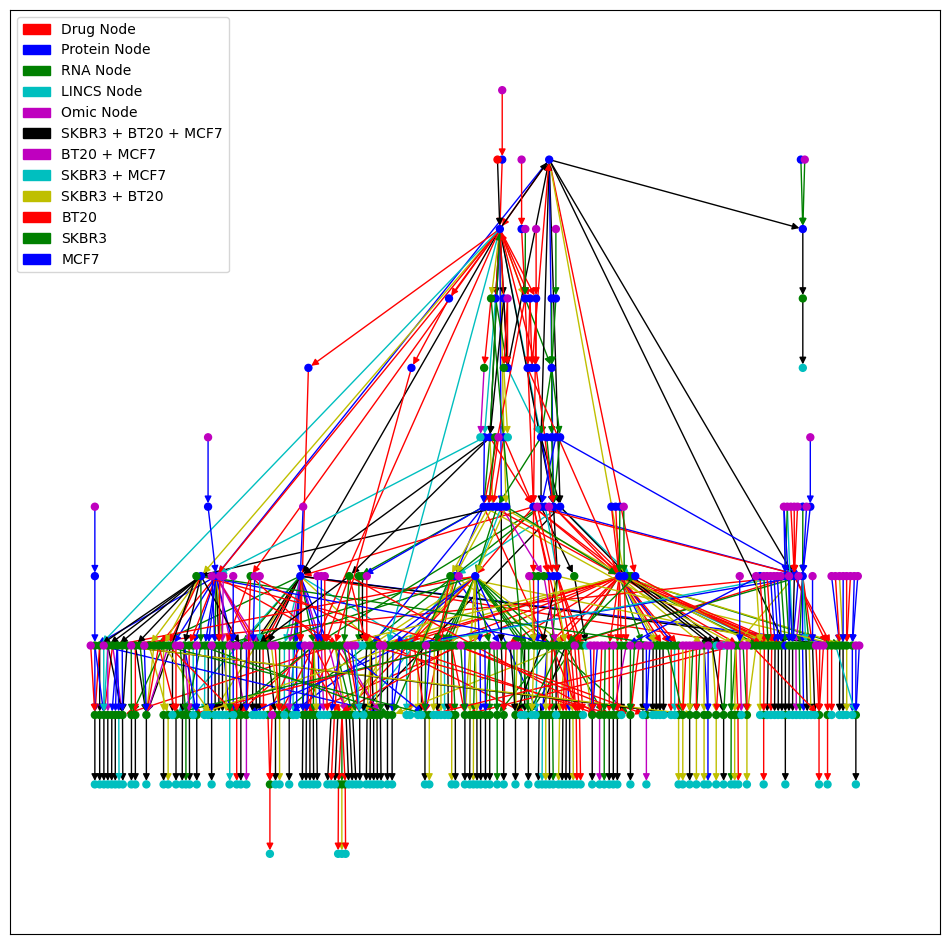

In [224]:
pos = nx.drawing.nx_agraph.graphviz_layout(G, prog='dot')

node_colors = [] 

_DRUGCOLOR = 'r'
_PROTEINCOLOR = 'b'
_RNACOLOR = 'g'
_LINCSCOLOR = 'c'
_OMICSCOLOR = 'm'

for node in G.nodes(): 

    type_ = node.split('__')[0]
    if type_ == 'DRUG': 
        node_colors.append(_DRUGCOLOR)
    elif type_ == 'PROTEIN': 
        node_colors.append(_PROTEINCOLOR)
    elif type_ == 'RNA': 
        node_colors.append(_RNACOLOR)
    elif type_ == 'LINCS': 
        node_colors.append(_LINCSCOLOR)
    else: 
        # omic node
        node_colors.append(_OMICSCOLOR)

edge_colors = []

_ALLLINES = 'k'
_BT_MC = 'm' # r + b  ~ purple 
_MC_SK = 'c' # b + g ~ cyan 
_BT_SK = 'y' # r + g ~ yellow
_BT = 'r'
_SK = 'g'
_MC = 'b'


for edge in G.edges():
    if G.edges[edge]['bt20'] & G.edges[edge]['mcf7'] & G.edges[edge]['skbr3']: 
        edge_colors.append(_ALLLINES)
    elif G.edges[edge]['bt20'] & G.edges[edge]['mcf7']: 
        edge_colors.append(_BT_MC)
    elif G.edges[edge]['mcf7'] & G.edges[edge]['skbr3']: 
        edge_colors.append(_MC_SK)
    elif G.edges[edge]['bt20'] & G.edges[edge]['skbr3']: 
        edge_colors.append(_BT_SK)
    elif G.edges[edge]['bt20']: 
        edge_colors.append(_BT)
    elif G.edges[edge]['mcf7']: 
        edge_colors.append(_MC)
    elif G.edges[edge]['skbr3']: 
        edge_colors.append(_SK)
    else: 
        edge_colors.append(_INACTIVEEDGE)

plt.figure(figsize=(12,12))

drug_patch = mpatches.Patch(color=_DRUGCOLOR, label='Drug Node')
prot_patch = mpatches.Patch(color=_PROTEINCOLOR, label='Protein Node')
_rna_patch = mpatches.Patch(color=_RNACOLOR, label='RNA Node')
linc_patch = mpatches.Patch(color=_LINCSCOLOR, label='LINCS Node')
omic_patch = mpatches.Patch(color=_OMICSCOLOR, label='Omic Node')

allmp = mpatches.Patch(color=_ALLLINES, label='SKBR3 + BT20 + MCF7')
btmcmp = mpatches.Patch(color=_BT_MC, label='BT20 + MCF7')
mcskmp = mpatches.Patch(color=_MC_SK, label='SKBR3 + MCF7')
btskmp = mpatches.Patch(color=_BT_SK, label='SKBR3 + BT20')
btmp = mpatches.Patch(color=_BT, label='BT20')
skmp = mpatches.Patch(color=_SK, label='SKBR3')
mcmp = mpatches.Patch(color=_MC, label='MCF7')

nx.draw_networkx_edges(G, pos=pos, node_size=25, edge_color=edge_colors)
nx.draw_networkx_nodes(G, pos=pos, node_size=25, node_color=node_colors, alpha=1.)
plt.legend(handles=[drug_patch, prot_patch, _rna_patch, linc_patch, omic_patch, allmp, btmcmp, mcskmp, btskmp, btmp, skmp, mcmp])

#plt.savefig(f'/mnt/c/Users/natha/Documents/neratinib_important_edges_{attr}.png', bbox_inches='tight', pad_inches=0.)
plt.show()

In [225]:
tfs = [] 
for i,row in nerdf2.iterrows(): 
    if (row.source.split('__')[0] == 'PROTEIN') & (row.target.split('__')[0] == 'RNA'): 
        tfs.append(row.source)

tfs = np.unique(tfs)
len(tfs)


28

In [226]:
uni2symb = pd.read_csv('../extdata/omnipath_uniprot2genesymb.tsv', sep='\t').set_index('From').to_dict()['To']

bt20


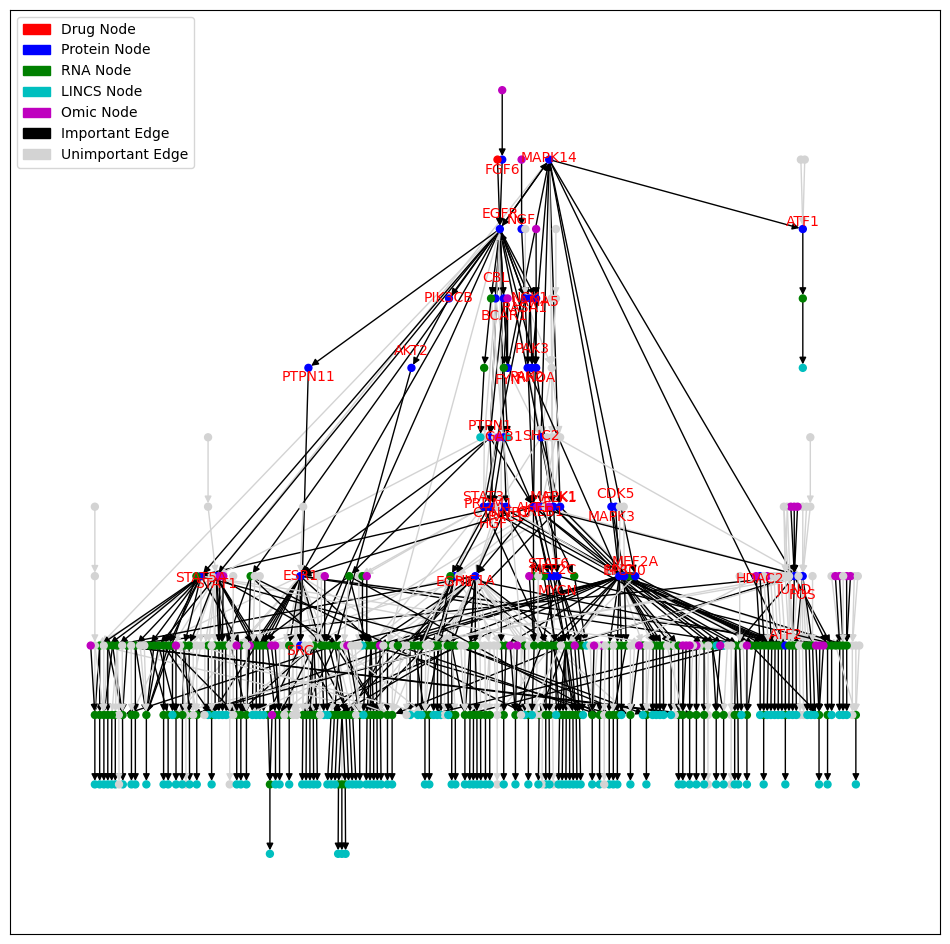

mcf7


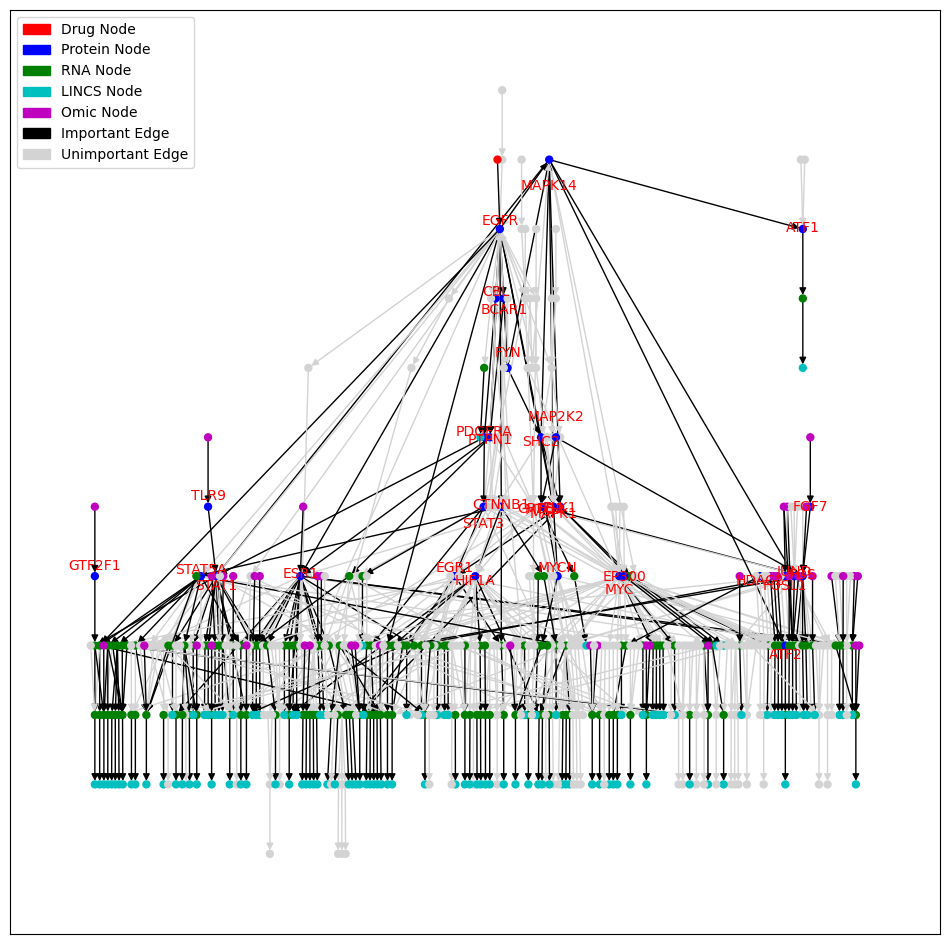

skbr3


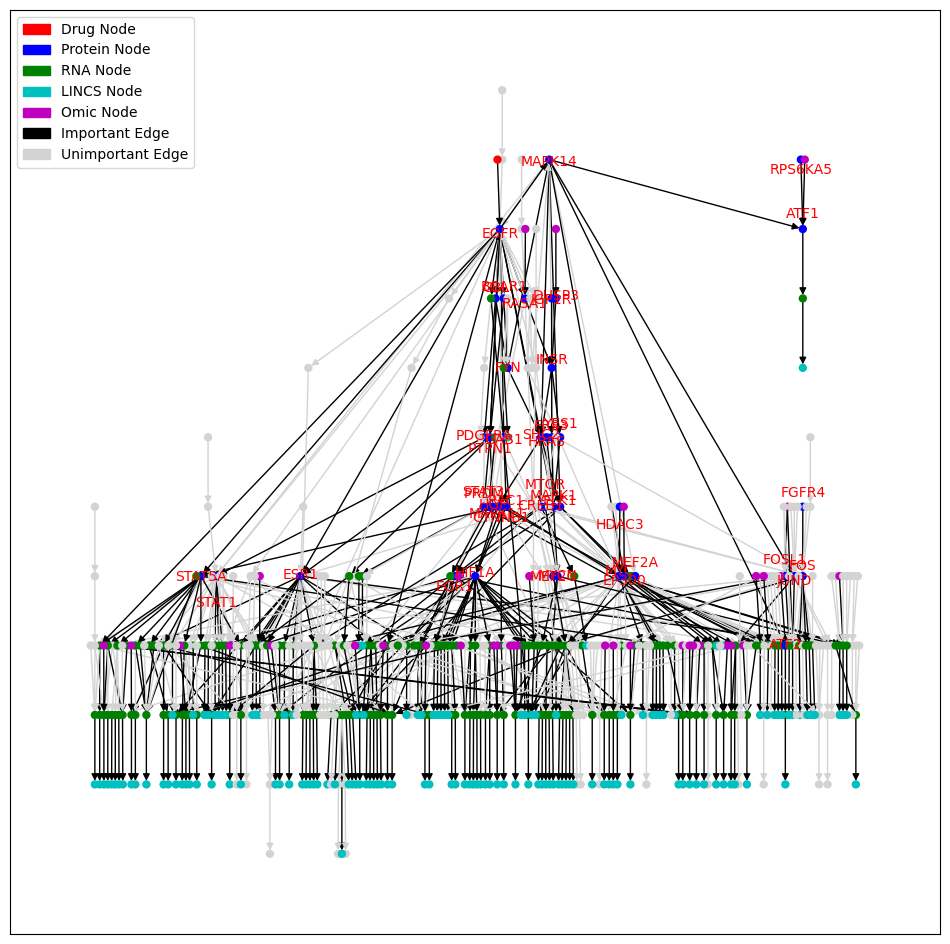

In [235]:
#NOTE: plots each cell line graph individually. 


pos = nx.drawing.nx_agraph.graphviz_layout(G, prog='dot')

for attr in ['bt20', 'mcf7', 'skbr3']: 
    print(attr)

    node_colors = [] 

    _DRUGCOLOR = 'r'
    _PROTEINCOLOR = 'b'
    _RNACOLOR = 'g'
    _LINCSCOLOR = 'c'
    _OMICSCOLOR = 'm'

    node_label_dict = {}

    for node in G.nodes(): 
        
        has_active_edge = False
        for edge in G.edges(node): 
            if G.edges[edge][attr]: 
                has_active_edge = True 
                break 
        for parent in G.predecessors(node): 
            if G.edges[(parent, node)][attr]: 
                has_active_edge = True 
                break 

        if not has_active_edge: 
            node_colors.append('lightgray')
        else: 

            type_ = node.split('__')[0]
            if type_ == 'DRUG': 
                node_colors.append(_DRUGCOLOR)
            elif type_ == 'PROTEIN': 
                node_label_dict[node] = uni2symb[node.split('__')[-1]]
                node_colors.append(_PROTEINCOLOR)
            elif type_ == 'RNA': 
                node_colors.append(_RNACOLOR)
            elif type_ == 'LINCS': 
                node_colors.append(_LINCSCOLOR)
            else: 
                # omic node
                node_colors.append(_OMICSCOLOR)

    edge_colors = []

    _ACTIVEEDGE = 'k'
    _INACTIVEEDGE = 'lightgray'

    for edge in G.edges():
        if G.edges[edge][attr]: 
            edge_colors.append(_ACTIVEEDGE)
        else: 
            edge_colors.append(_INACTIVEEDGE)

    plt.figure(figsize=(12,12))

    drug_patch = mpatches.Patch(color=_DRUGCOLOR, label='Drug Node')
    prot_patch = mpatches.Patch(color=_PROTEINCOLOR, label='Protein Node')
    _rna_patch = mpatches.Patch(color=_RNACOLOR, label='RNA Node')
    linc_patch = mpatches.Patch(color=_LINCSCOLOR, label='LINCS Node')
    omic_patch = mpatches.Patch(color=_OMICSCOLOR, label='Omic Node')

    active_patch = mpatches.Patch(color=_ACTIVEEDGE, label='Important Edge')
    inactive_patch = mpatches.Patch(color=_INACTIVEEDGE, label='Unimportant Edge')

    nx.draw_networkx_edges(G, pos=pos, node_size=25, edge_color=edge_colors)
    nx.draw_networkx_labels(G, pos={k:(x, y+10*np.random.randn(1).item()) for k, (x,y) in pos.items()}, font_size=10, labels=node_label_dict, font_color='r', font_weight='normal')
    nx.draw_networkx_nodes(G, pos=pos, node_size=25, node_color=node_colors, alpha=1.)
    plt.legend(handles=[drug_patch, prot_patch, _rna_patch, linc_patch, omic_patch, active_patch, inactive_patch])
    
    #plt.savefig(f'/mnt/c/Users/natha/Documents/neratinib_important_edges_{attr}.png', bbox_inches='tight', pad_inches=0.)
    #plt.savefig(f'../extdata/neratinib_important_edges_{attr}.png', bbox_inches='tight', pad_inches=0.)
    plt.show()

In [229]:
# load ppi context 
ppicontext = pd.read_csv('../../data/ppi_context_v_1_00.txt', sep='\t')
ppicontext.head()

,id,gene_a,gene_b,pid,cell_name,cell_category,cell_sex,cell_species
0,0,ALDH1A1,ALDH1A1,25416956,HEK,Cancer cell line,Female,Homo sapiens
1,2,PPP1R9A,ACTG1,9362513,Rat1,Spontaneously immortalized cell line,NaN,Rattus norvegicus
2,2,PPP1R9A,ACTG1,9362513,PC12,Cancer cell line,Male,Rattus norvegicus
3,2,PPP1R9A,ACTG1,9362513,Sf9,Spontaneously immortalized cell line,Female,Spodoptera frugiperda
4,2,PPP1R9A,ACTG1,9362513,COS-7,Transformed cell line,Male,Chlorocebus aethiops


In [230]:
[x for x in np.sort(ppicontext.cell_name.unique()).tolist() if 'SK' in x]

['IGSK-1',
 'SK 7',
 'SK-BR-3',
 'SK-BR-7',
 'SK-CO-1',
 'SK-GT-4',
 'SK-HEP-1',
 'SK-LMS-1',
 'SK-LU-1',
 'SK-MEL-1',
 'SK-MEL-10',
 'SK-MEL-100',
 'SK-MEL-103',
 'SK-MEL-108',
 'SK-MEL-14',
 'SK-MEL-147',
 'SK-MEL-2',
 'SK-MEL-239',
 'SK-MEL-24',
 'SK-MEL-28',
 'SK-MEL-31',
 'SK-MEL-37',
 'SK-MEL-5',
 'SK-MES-1',
 'SK-MG-13',
 'SK-MG-7',
 'SK-MM-1',
 'SK-N-AS',
 'SK-N-BE(2)',
 'SK-N-BE(2)-C',
 'SK-N-DZ',
 'SK-N-MC',
 'SK-N-SH',
 'SK-NEP-1',
 'SK-OV-3',
 'SK-PC-1',
 'SK-RC-10',
 'SK-RC-47',
 'SK-UT-1',
 'SKI-DLCL-1',
 'SKNO-1',
 'SKOV3.ip1',
 'SKW 6.4']

In [231]:
nerdf3 = nerdf2 # nerdf2[lambda x: x.source.str.contains('PROTEIN__') & x.target.str.contains('PROTEIN__')][lambda x: x.source.isin(G.nodes()) & x.target.isin(G.nodes())]
print(nerdf3.shape)
nerdf3 = nerdf3.assign(gene_a = lambda x: [uni2symb[x.split('__')[-1]] if x.split('__')[-1] in uni2symb else None for x in x.source.values])
nerdf3 = nerdf3.assign(gene_b = lambda x: [uni2symb[x.split('__')[-1]] if x.split('__')[-1] in uni2symb else None for x in x.target.values])
nerdf3.head()

(1119, 10)


,source,target,bt20_score,mcf7_score,skbr3_score,bt20,mcf7,skbr3,at_least_one,all_three,gene_a,gene_b
62,PROTEIN__P03372,RNA__P01133,0.004576,0.019080,0.998452,False,False,True,True,False,ESR1,EGF
65,PROTEIN__P01106,RNA__P24522,0.857481,0.005441,0.010817,True,False,False,True,False,MYC,GADD45A
107,PROTEIN__P03372,RNA__Q9Y6Q9,0.002330,0.623740,0.582074,False,True,True,True,False,ESR1,NCOA3
119,PROTEIN__P01106,RNA__P46695,0.488658,0.002396,0.863626,False,False,True,True,False,MYC,IER3
123,PROTEIN__P01106,RNA__Q02363,0.021752,0.010153,0.976913,False,False,True,True,False,MYC,ID2


In [232]:
# ppi context, subset to the 3 cell line world. e.g., only include a ppi context if it appears in at least one of the three cell lines 
ppicontext2 = ppicontext.merge(nerdf3[['gene_a', 'gene_b']], on=['gene_a', 'gene_b'], how='inner')[['gene_a', 'gene_b', 'cell_name']].drop_duplicates()

In [233]:
nerdf3_bt20 = nerdf3[lambda x: x.bt20][['gene_a','gene_b']].assign(IMPORTANT_EDGE=True)

# number of important MCF7 edges that were also reported in PPI context 
bt20_res_ = nerdf3_bt20.merge(ppicontext2[lambda x: x.cell_name == 'BT-20'], on=['gene_a', 'gene_b'], how='right')

FP = bt20_res_.IMPORTANT_EDGE.isna().sum()
TP = bt20_res_.IMPORTANT_EDGE.sum() 
PPV = TP / (TP + FP)
FDR = 1 - PPV

print(TP, FP)
print(PPV, FDR)

0 0
nan nan


invalid value encountered in long_scalars


In [234]:
nerdf3_mcf7 = nerdf3[lambda x: x.mcf7][['gene_a','gene_b']].assign(IMPORTANT_EDGE=True).drop_duplicates()

# number of important MCF7 edges that were also reported in PPI context 
mcf7_res_ = nerdf3_mcf7.merge(ppicontext2[lambda x: x.cell_name == 'MCF-7'], on=['gene_a', 'gene_b'], how='right')

FP = mcf7_res_.IMPORTANT_EDGE.isna().sum()
TP = mcf7_res_.IMPORTANT_EDGE.sum() 
PPV = TP / (TP + FP)
FDR = 1 - PPV

print(TP, FP)
print(PPV, FDR)

null_fdr = []
for i in range(1000): 

    rand_mask = np.random.permutation(nerdf3.mcf7.values)
    #rand_mask = np.random.randn(nerdf3.mcf7.values.shape[0]) > 0

    nerdf3_rand = nerdf3[rand_mask][['gene_a','gene_b']].assign(IMPORTANT_EDGE=True)

    # number of important MCF7 edges that were also reported in PPI context 
    rand_res_ = nerdf3_rand.merge(ppicontext2[lambda x: x.cell_name == 'MCF-7'], on=['gene_a', 'gene_b'], how='right')

    FP_ = rand_res_.IMPORTANT_EDGE.isna().sum()
    TP_ = rand_res_.IMPORTANT_EDGE.sum() 
    PPV_ = TP_ / (TP_ + FP_)
    FDR_ = 1 - PPV_

    null_fdr.append(FDR_)

# probability of being attained by random
1-(FDR < null_fdr).mean()

null_fdr


8 13
0.38095238095238093 0.6190476190476191


[0.4,
 0.31034482758620685,
 0.48,
 0.4782608695652174,
 0.23076923076923073,
 0.4782608695652174,
 0.42307692307692313,
 0.41666666666666663,
 0.22580645161290325,
 0.23076923076923073,
 0.5454545454545454,
 0.42307692307692313,
 0.2857142857142857,
 0.40740740740740744,
 0.5238095238095238,
 0.31034482758620685,
 0.28,
 0.2592592592592593,
 0.24137931034482762,
 0.34615384615384615,
 0.4,
 0.25,
 0.29166666666666663,
 0.2727272727272727,
 0.16000000000000003,
 0.43999999999999995,
 0.2592592592592593,
 0.19999999999999996,
 0.45833333333333337,
 0.23076923076923073,
 0.22580645161290325,
 0.24,
 0.27586206896551724,
 0.42307692307692313,
 0.34615384615384615,
 0.33333333333333337,
 0.28,
 0.31999999999999995,
 0.28,
 0.24,
 0.31999999999999995,
 0.52,
 0.18518518518518523,
 0.3846153846153846,
 0.25,
 0.3076923076923077,
 0.24137931034482762,
 0.4,
 0.2142857142857143,
 0.24137931034482762,
 0.23076923076923073,
 0.2692307692307693,
 0.1428571428571429,
 0.33333333333333337,
 0.14285

In [552]:
for i,row in mcf7_res_.assign(GSNN_EDGE = lambda x: x.IMPORTANT_EDGE == True).iterrows(): 
    print(f'{row.gene_a} & {row.gene_b} & {row.GSNN_EDGE}', end=' \\\\ \\hline\n')

BRCA1 & BRCA1 & True \\ \hline
SQSTM1 & SQSTM1 & True \\ \hline
AKT1 & AKT1 & False \\ \hline
BNIP3 & BNIP3 & False \\ \hline
EP300 & EP300 & False \\ \hline
PAK4 & PAK4 & False \\ \hline
STAT3 & HIF1A & True \\ \hline
EGFR & EGFR & True \\ \hline
EGFR & CBL & True \\ \hline
ESR1 & ESR1 & True \\ \hline
EP300 & ESR1 & True \\ \hline
FGFR4 & FGFR4 & False \\ \hline
IKBKE & IKBKE & False \\ \hline
APP & APP & True \\ \hline
MYC & MYC & False \\ \hline
STUB1 & STUB1 & True \\ \hline
CDK4 & CDK4 & False \\ \hline
HIF1A & VEGFA & False \\ \hline
AKT1 & HIF1A & False \\ \hline
HGF & MYC & False \\ \hline
PIK3CA & MYC & False \\ \hline
HK1 & HK1 & False \\ \hline


In [498]:
nerdf3_skbr3 = nerdf3[lambda x: x.skbr3][['gene_a','gene_b']].assign(IMPORTANT_EDGE=True)

# number of important MCF7 edges that were also reported in PPI context 
skbr3_res_ = nerdf3_skbr3.merge(ppicontext2[lambda x: x.cell_name == 'SK-BR-3'], on=['gene_a', 'gene_b'], how='right')

FP = skbr3_res_.IMPORTANT_EDGE.isna().sum()
TP = skbr3_res_.IMPORTANT_EDGE.sum() 
PPV = TP / (TP + FP)
FDR = 1 - PPV

print(TP, FP)
print(PPV, FDR)



0 0
nan nan


invalid value encountered in long_scalars


In [ ]:
nerdf3_bt20 = nerdf3[lambda x: x.bt20]
nerdf3_bt20.merge(ppicontext[lambda x: x.cell_name == 'BT-20'], on=['gene_a', 'gene_b'], how='inner')

In [ ]:
set(list(pos.keys())).difference(set(list(G.nodes())))

set()

In [ ]:
set(list(pos.keys()))

{'DRUG__BRD-K85606544',
 'LINCS__O00273',
 'LINCS__O00762',
 'LINCS__O14503',
 'LINCS__O15118',
 'LINCS__O15392',
 'LINCS__O15503',
 'LINCS__O43463',
 'LINCS__O43502',
 'LINCS__O43524',
 'LINCS__O60239',
 'LINCS__O60936',
 'LINCS__O75828',
 'LINCS__O94782',
 'LINCS__O95084',
 'LINCS__O95456',
 'LINCS__O96017',
 'LINCS__O96020',
 'LINCS__P00491',
 'LINCS__P00533',
 'LINCS__P03956',
 'LINCS__P04035',
 'LINCS__P04075',
 'LINCS__P04626',
 'LINCS__P05067',
 'LINCS__P05362',
 'LINCS__P05412',
 'LINCS__P06493',
 'LINCS__P07711',
 'LINCS__P09493',
 'LINCS__P09601',
 'LINCS__P09874',
 'LINCS__P0DMV9',
 'LINCS__P10244',
 'LINCS__P10809',
 'LINCS__P11142',
 'LINCS__P11388',
 'LINCS__P11717',
 'LINCS__P12004',
 'LINCS__P14635',
 'LINCS__P16949',
 'LINCS__P17861',
 'LINCS__P18669',
 'LINCS__P18846',
 'LINCS__P18858',
 'LINCS__P19526',
 'LINCS__P19875',
 'LINCS__P20248',
 'LINCS__P22061',
 'LINCS__P22234',
 'LINCS__P24522',
 'LINCS__P24941',
 'LINCS__P25205',
 'LINCS__P25963',
 'LINCS__P26358',
 'LI

In [ ]:
set(list(G.nodes()))

{'CNV__O15118',
 'CNV__O60239',
 'CNV__O96020',
 'CNV__P00533',
 'CNV__P01100',
 'CNV__P01106',
 'CNV__P04198',
 'CNV__P06213',
 'CNV__P06241',
 'CNV__P06493',
 'CNV__P09493',
 'CNV__P09601',
 'CNV__P10244',
 'CNV__P15407',
 'CNV__P20936',
 'CNV__P35269',
 'CNV__P51452',
 'CNV__P84022',
 'CNV__Q06413',
 'CNV__Q12983',
 'CNV__Q13145',
 'CNV__Q15011',
 'CNV__Q6FI81',
 'CNV__Q96ST3',
 'CNV__Q9NX09',
 'CNV__Q9Y6Q9',
 'DRUG__BRD-K85606544',
 'EXPR__O43502',
 'EXPR__O75828',
 'EXPR__O96020',
 'EXPR__P00533',
 'EXPR__P04035',
 'EXPR__P04198',
 'EXPR__P04626',
 'EXPR__P09493',
 'EXPR__P09601',
 'EXPR__P10244',
 'EXPR__P12004',
 'EXPR__P15336',
 'EXPR__P15407',
 'EXPR__P16949',
 'EXPR__P27694',
 'EXPR__P38936',
 'EXPR__P46937',
 'EXPR__P78552',
 'EXPR__P84022',
 'EXPR__Q02363',
 'EXPR__Q05932',
 'EXPR__Q09472',
 'EXPR__Q13145',
 'EXPR__Q13480',
 'EXPR__Q6FI81',
 'EXPR__Q9NX09',
 'EXPR__Q9UKW4',
 'EXPR__Q9Y376',
 'LINCS__O00273',
 'LINCS__O00762',
 'LINCS__O14503',
 'LINCS__O15118',
 'LINCS__O15

KeyError: 'PROTEIN__P01100'

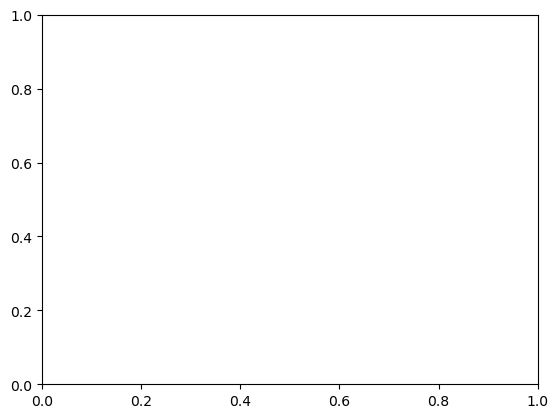

In [ ]:
plt.figure()
nx.draw_networkx_edges(G, pos=pos)

plt.show()

In [ ]:
model.cpu()(X[[1502]])[:, ELK_LINCS_targ_idxs]

tensor([[ 0.4045,  1.1248,  3.8501,  0.4797, -1.4882, -2.3810,  0.7249, -2.2067,
         -0.1551,  0.3875, -1.3970]])

In [ ]:
model.cpu()(X[[16495]])[:, ELK_LINCS_targ_idxs]

tensor([[ 0.1636,  0.1775,  2.6569,  0.8054, -0.9038,  0.8106,  0.6587,  0.1596,
         -0.0127, -0.3620, -1.0718]])

In [ ]:
# lung cancer 
ELK_NERATINIB_A549 = explainer.explain(X[[18915]], targets=ELK_LINCS_targ_idxs, weight_decay=0, beta=10, iters=1000)

In [ ]:
model.cpu()(X[[18915]])[:, ELK_LINCS_targ_idxs]

tensor([[ 0.4355,  0.0196,  1.4991,  0.5416, -0.5329, -0.3395,  0.3494,  0.1289,
         -0.1935,  0.1341, -0.3573]])

In [ ]:
# melanoma (skin cancer)
ELK_NERATINIB_A375 = explainer.explain(X[[22366]], targets=ELK_LINCS_targ_idxs, weight_decay=0, beta=10, iters=1000)

In [ ]:
model.cpu()(X[[22366]])[:, ELK_LINCS_targ_idxs]

tensor([[ 0.8208,  0.2433,  1.2894,  0.4925, -0.5565, -0.3107,  0.3159,  0.0357,
          0.0125,  0.3991, -1.0475]])

In [ ]:
ELK_NERATINIB_PC3[lambda x: x.score > 0.5][lambda x: x.source.str.contains('DRUG__')]

,source,target,score
10328,DRUG__BRD-K07955840,PROTEIN__P42345,0.978079
10702,DRUG__BRD-K52522949,PROTEIN__O15379,1.000000
10839,DRUG__BRD-K64606589,PROTEIN__O15379,0.999949
10861,DRUG__BRD-K68174511,PROTEIN__P42345,1.000000
11165,DRUG__BRD-K86797399,PROTEIN__O15379,1.000000


In [ ]:
ELK_NERATINIB_A549[lambda x: x.score > 0.5][lambda x: x.source.str.contains('DRUG__')]

,source,target,score
11165,DRUG__BRD-K86797399,PROTEIN__O15379,0.999999


In [ ]:
BRD-K85606544

In [ ]:
src

array(['PROTEIN__P01106', 'PROTEIN__P42224', 'PROTEIN__P40763', ...,
       'MUT__Q9Y6I3', 'MUT__Q9Y6N6', 'MUT__Q9Y6W5'], dtype='<U19')

In [ ]:
sigidinfo[lambda x: x.pert_id == 'BRD-K61397605'][['pert_id', 'pert_dose', 'sig_id']]

,pert_id,pert_dose,sig_id
1010,BRD-K61397605,1.111110,REP.A015_A375_24H:P15
1665,BRD-K61397605,2.307690,REP.B015_PC3_24H:P13
1829,BRD-K61397605,2.307690,REP.B015_MCF7_24H:P13
2828,BRD-K61397605,0.769231,REP.B015_MCF7_24H:P14
3026,BRD-K61397605,0.256410,REP.B015_MCF7_24H:P15
...,...,...,...
26930,BRD-K61397605,0.085470,REP.B015_PC3_24H:P16
27088,BRD-K61397605,3.333330,REP.A015_PC3_24H:P14
27170,BRD-K61397605,0.041152,REP.A015_PC3_24H:P18
27607,BRD-K61397605,10.000000,LKCP001_U2OS_24H:D22


# Example Plots 

Plot 3 different cell lines; same drug and dose. 

Target 

# GSNNExplainer Replicate Stability 

In [ ]:
xidx = 1665 
sig_ids[xidx]

'REP.B015_PC3_24H:P13'

In [ ]:
# tip: strong prior, big beta and run until it converges (lots of iters)

explainer = GSNNExplainer(model, data, hard=True, prior=2)
edgedf1 = explainer.explain(X[[xidx]], targets=data.output_node_mask.nonzero(as_tuple=True)[0], weight_decay=0, beta=10, iters=1000)
edgedf2 = explainer.explain(X[[xidx]], targets=data.output_node_mask.nonzero(as_tuple=True)[0], weight_decay=0, beta=10, iters=1000)
#edgedf2 = explainer.explain(X[[xidx]], targets=None, lr=1e-2, beta=1e-1, batch=25)

In [ ]:
confusion_matrix(edgedf1.score > 0.5, edgedf2.score > 0.5)

array([[14263,    53],
       [   45,  1453]])

In [ ]:
confusion_matrix(edgedf1.score > 0.5, edgedf2.score > 0.5) / len(edgedf1)

array([[0.90192235, 0.00335146],
       [0.00284558, 0.09188061]])

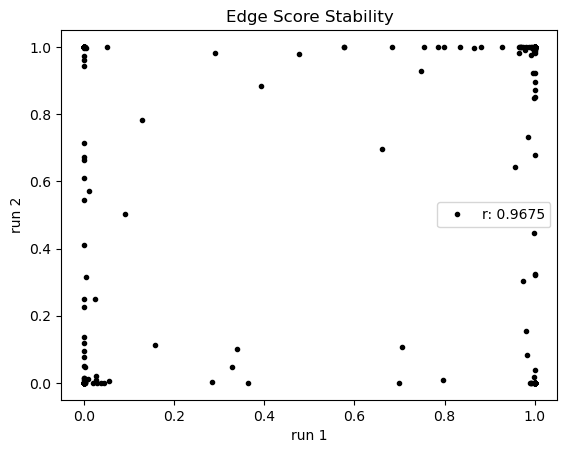

In [ ]:
plt.figure()
plt.plot(edgedf1.score, edgedf2.score, 'k.', label=f'r: {np.corrcoef(edgedf1.score, edgedf2.score)[0,1]:.4f}')
plt.xlabel('run 1')
plt.ylabel('run 2')
plt.title('Edge Score Stability')
plt.legend()
plt.show()

In [ ]:
subedges = edgedf1[lambda x: x.score > 0.5]
subnodes = np.unique(subedges.source.values.tolist() + subedges.target.values.tolist())
len(subnodes)

1157

In [ ]:
edgedf1[lambda x: x.source.str.contains('DRUG__')].sort_values(by='score', ascending=False).head(10)#[lambda x: x.source == 'DRUG__' + siginfo.set_index('sig_id').loc[sig_ids[xidx]][['pert_id']].item()]

,source,target,score
10758,DRUG__BRD-K61397605,PROTEIN__Q13547,1.000000e+00
10756,DRUG__BRD-K61397605,PROTEIN__O15379,9.999999e-01
10299,DRUG__BRD-K02130563,PROTEIN__Q92769,7.854854e-09
11165,DRUG__BRD-K86797399,PROTEIN__O15379,1.125857e-09
10759,DRUG__BRD-K61397605,PROTEIN__Q92769,1.099427e-09
10391,DRUG__BRD-K17743125,PROTEIN__O15379,4.231074e-10
10364,DRUG__BRD-K14529030,PROTEIN__P40763,3.779971e-10
10354,DRUG__BRD-K12867552,PROTEIN__O15379,3.115291e-10
10770,DRUG__BRD-K64052750,PROTEIN__O15264,3.001712e-10
10839,DRUG__BRD-K64606589,PROTEIN__O15379,2.639504e-10


In [ ]:
edgedf2[lambda x: x.source.str.contains('DRUG__')].sort_values(by='score', ascending=False).head(10)#[lambda x: x.source == 'DRUG__' + siginfo.set_index('sig_id').loc[sig_ids[xidx]][['pert_id']].item()]

,source,target,score
10758,DRUG__BRD-K61397605,PROTEIN__Q13547,1.000000e+00
10756,DRUG__BRD-K61397605,PROTEIN__O15379,9.225526e-01
10299,DRUG__BRD-K02130563,PROTEIN__Q92769,1.660771e-08
11165,DRUG__BRD-K86797399,PROTEIN__O15379,1.952612e-09
10759,DRUG__BRD-K61397605,PROTEIN__Q92769,9.561572e-10
10391,DRUG__BRD-K17743125,PROTEIN__O15379,4.841070e-10
10354,DRUG__BRD-K12867552,PROTEIN__O15379,4.203508e-10
10770,DRUG__BRD-K64052750,PROTEIN__O15264,3.101625e-10
10364,DRUG__BRD-K14529030,PROTEIN__P40763,3.055998e-10
10987,DRUG__BRD-K78431006,PROTEIN__O15264,2.711086e-10
